# 读取 .xyz文件 处理不同温度下稳定的结构

每10000帧保存一个温度的结构

## 处理流程
1. 读取1-trajectory.xyz
2. 每10000帧提取一次结构（初始温度0k，共25步，步长25k）
3. 处理每帧数据，延y轴切面，构建xz面
4. 因原子不在统一xz平面，根据间隔范围，选取平面
5. 根据选取的平面，构建xz面，计算偏移向量
6. 根据偏移向量，构建热力图
7. 根据热力图，绘制箭头



In [1]:
import numpy as np
import yaml
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy.typing as npt
import seaborn as sns

from MDAnalysis import Universe
from dataclasses import dataclass
from pymatgen.core import Structure
from pymatgen.io.vasp import Poscar
from matplotlib import gridspec
from caesar.logger.logger import setup_logger
from pathlib import Path
from typing import List, Dict, Any, Tuple
from matplotlib import rcParams


config = {
    "font.family": 'serif',
    # "font.size": 20,
    "mathtext.fontset": 'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)


logger = setup_logger(__name__)

In [38]:
xyzfile='./data/1-trajectory.xyz'

In [3]:
# 构建原始坐标
def build_pm3m_coord():
    pm3m_Ti_coord=[]
    lattice_constance=3.9127
    for i in range(40):
        for j in range(20):
            for k in range(20):
                pm3m_Ti_coord.append([lattice_constance*i,lattice_constance*j,lattice_constance*k])
    
    return np.array(pm3m_Ti_coord)

pm3m_Ti_coord=build_pm3m_coord()

with open('./data/pm3m_Ti_coord.npy','wb') as f:
    np.save(f,pm3m_Ti_coord)




In [9]:
def extract_timesteps(input_file, output_dir):
    # 创建输出目录
    os.makedirs(output_dir, exist_ok=True)
    
    with open(input_file, 'r') as f_in:
        frame_count = 0
        while True:
            # 跳过原子数量行
            n_atoms_line = f_in.readline()
            if not n_atoms_line:  # 文件结束
                logger.error('文件结束')
                break
            
            # 读取并解析Timestep行
            timestep_line = f_in.readline()
            if not timestep_line:
                logger.error('文件结束')
                break
            
            try:
                ts_value = int(timestep_line.strip().split()[-1])
            except (IndexError, ValueError):
                logger.exception(f"跳过无效时间步: {timestep_line.strip()}")
                continue

            # 验证原子数量格式
            try:
                n_atoms = int(n_atoms_line.strip())
            except ValueError:
                logger.exception(f"无效原子数: {n_atoms_line.strip()}")
                continue

            # 读取原子数据块
            data_lines = []
            valid_block = True
            for _ in range(n_atoms):
                if (data_line := f_in.readline()):
                    data_lines.append(data_line)
                else:
                    valid_block = False
                    break
            
            if not valid_block:
                break

            # 筛选时间步
            if ts_value % 10000 == 0:
                # 生成纯数据文件
                output_path = os.path.join(output_dir, f"frame_{ts_value}.dat")
                with open(output_path, 'w') as f_out:
                    f_out.writelines(data_lines)
                logger.info(f"生成文件: {output_path} (包含 {len(data_lines)} 行原子数据)")

extract_timesteps(xyzfile, "./data/frames/")


[2025-02-17 22:42:38.590075 INFO   ] 1279643876:extract_timesteps:50 - 生成文件: ./data/frames/frame_0.dat (包含 80000 行原子数据)


[2025-02-17 22:42:39.425258 INFO   ] 1279643876:extract_timesteps:50 - 生成文件: ./data/frames/frame_10000.dat (包含 80000 行原子数据)
[2025-02-17 22:42:40.297253 INFO   ] 1279643876:extract_timesteps:50 - 生成文件: ./data/frames/frame_20000.dat (包含 80000 行原子数据)
[2025-02-17 22:42:41.165167 INFO   ] 1279643876:extract_timesteps:50 - 生成文件: ./data/frames/frame_30000.dat (包含 80000 行原子数据)
[2025-02-17 22:42:42.019126 INFO   ] 1279643876:extract_timesteps:50 - 生成文件: ./data/frames/frame_40000.dat (包含 80000 行原子数据)
[2025-02-17 22:42:42.888357 INFO   ] 1279643876:extract_timesteps:50 - 生成文件: ./data/frames/frame_50000.dat (包含 80000 行原子数据)
[2025-02-17 22:42:43.704174 INFO   ] 1279643876:extract_timesteps:50 - 生成文件: ./data/frames/frame_60000.dat (包含 80000 行原子数据)
[2025-02-17 22:42:44.501670 INFO   ] 1279643876:extract_timesteps:50 - 生成文件: ./data/frames/frame_70000.dat (包含 80000 行原子数据)
[2025-02-17 22:42:45.324219 INFO   ] 1279643876:extract_timesteps:50 - 生成文件: ./data/frames/frame_80000.dat (包含 80000 行原子数据)
[2025-02

In [16]:
# 原子种类
atom_species_dict = {
    1: 'Pb',
    2: 'Sr',
    3: 'Ti',
    4: 'O'
}

In [2]:
def read_frame_data(frame_path):
    with open(frame_path, 'r') as f_in:
        data_lines = [[float(j) for j in i.strip().split()] for i in f_in.readlines()]
    return np.array(data_lines)

data_frame=read_frame_data('./data/frames/frame_0.dat')
data_frame

array([[  1.     ,   5.85735,   1.95245,  76.4917 ],
       [  1.     ,   1.95245,   5.85735,  76.4917 ],
       [  1.     ,   1.95245,   1.95245,  76.4917 ],
       ...,
       [  4.     , 154.244  ,  77.934  ,   0.     ],
       [  4.     , 150.339  ,  70.4522 ,   0.     ],
       [  4.     , 154.244  ,  74.3571 ,   0.     ]])

In [17]:
import numpy as np
import os

def lattice_slicing(y_coords, lattice_constant=3.9127, tolerance=0.5):
    """
    晶格参数分区生成器
    参数：
    y_coords: y坐标数组
    lattice_constant: 晶格常数 (Å)
    tolerance: 允许波动范围 (±值)
    """
    y_min, y_max = np.min(y_coords), np.max(y_coords)
    
    # 计算有效晶面数量
    n_min = int(np.floor((y_min - tolerance) / lattice_constant))
    n_max = int(np.ceil((y_max + tolerance) / lattice_constant))
    
    # 生成晶面中心坐标
    centers = np.arange(n_min, n_max+1) * lattice_constant
    
    # 生成边界区间
    bin_edges = np.sort(np.concatenate([
        centers - tolerance,
        centers + tolerance
    ]))
    
    # 限制在实际坐标范围内
    return np.clip(bin_edges, y_min, y_max)

def process_polarization(data_array, atom_type=3, output_dir="./lattice_slices"):
    # 筛选目标原子
    filtered = data_array[data_array[:,0] == atom_type]
    if len(filtered) == 0:
        logger.warning(f"未找到类型 {atom_type} 的原子")
        return
    
    y_coords = filtered[:,2]
    
    # 生成晶格分区
    bin_edges = lattice_slicing(y_coords)
    num_slices = len(bin_edges) // 2  # 每个晶面对应两个边界
    
    # 创建输出目录
    os.makedirs(output_dir, exist_ok=True)
    
    # 保存每个晶面
    results = []
    for i in range(num_slices):
        y_start = bin_edges[2*i]
        y_end = bin_edges[2*i+1]
        
        # 筛选区间原子
        mask = (y_coords >= y_start) & (y_coords <= y_end)
        slice_data = filtered[mask]
        
        # 生成文件名
        filename = f"plane_{i:02d}_y_{y_start:.3f}-{y_end:.3f}.dat"
        filepath = os.path.join(output_dir, filename)
        
        # 保存完整坐标数据
        np.savetxt(filepath, 
                 slice_data[:, 1:4],  # x,y,z 三列
                 fmt='%.5f',
                 header=f"Lattice plane {i}\nY range: [{y_start:.3f}, {y_end:.3f}]\nX\tY\tZ",
                 comments='')
        
        # 记录统计信息
        results.append({
            "plane": i,
            "y_range": (y_start, y_end),
            "atom_count": len(slice_data),
            "x_mean": slice_data[:,1].mean(),
            "y_mean": slice_data[:,2].mean(),
            "z_mean": slice_data[:,3].mean()
        })
    
    # 输出统计报告
    logger.info("晶面分布分析：")
    logger.info(f"{'晶面':<9} {'Y范围':<10} {'原子数':<8} {'X平均':<7} {'Y平均':<7} {'Z平均':<7}")
    for r in results:
        logger.info(f"{r['plane']:03d}  [{r['y_range'][0]:<7.3f}, {r['y_range'][1]:>7.3f}]  "
              f"{r['atom_count']:<8}  {r['x_mean']:.3f}    {r['y_mean']:.3f}    {r['z_mean']:.3f}")

# 使用示例
if __name__ == "__main__":
    # 示例数据生成
    np.random.seed(42)
    y_base = np.arange(-5, 6) * 3.9127  # 生成理论晶面
    y_noise = np.random.uniform(-0.05, 0.05, 1000)  # 添加微小扰动
    
    sample_data = np.column_stack([
        np.ones(1000)*3,                # 原子类型
        np.random.rand(1000)*10,        # x坐标 
        y_base[np.random.randint(0, 11, 1000)] + y_noise,  # y坐标
        np.random.rand(1000)*10         # z坐标
    ])
    
    process_polarization(data_frame)


[2025-02-18 10:07:22.012436 INFO   ] 1179880839:process_polarization:78 - 晶面分布分析：
[2025-02-18 10:07:22.013435 INFO   ] 1179880839:process_polarization:79 - 晶面        Y范围        原子数      X平均     Y平均     Z平均    
[2025-02-18 10:07:22.013435 INFO   ] 1179880839:process_polarization:81 - 000  [0.000  ,   0.000]  800       76.146    0.000    37.265
[2025-02-18 10:07:22.014436 INFO   ] 1179880839:process_polarization:81 - 001  [0.000  ,   0.500]  800       76.146    0.000    37.265
[2025-02-18 10:07:22.014436 INFO   ] 1179880839:process_polarization:81 - 002  [3.413  ,   4.413]  800       76.146    3.905    37.265
[2025-02-18 10:07:22.014901 INFO   ] 1179880839:process_polarization:81 - 003  [7.325  ,   8.325]  800       76.146    7.810    37.265
[2025-02-18 10:07:22.014901 INFO   ] 1179880839:process_polarization:81 - 004  [11.238 ,  12.238]  800       76.146    11.715    37.265
[2025-02-18 10:07:22.014901 INFO   ] 1179880839:process_polarization:81 - 005  [15.151 ,  16.151]  800       76.14

In [35]:
import numpy as np
from caesar.logger.logger import setup_logger

logger = setup_logger(__name__)

def read_frame(file_path):
    with open(file_path, 'r') as f:
        logger.info(f"读取文件: {file_path}")
        data = []
        for line in f.readlines():
            values = line.strip().split()
            if values and float(values[0]) == 3:  # 判断第一个元素是否为3
                data.append([float(i) for i in values])
    return np.array(data)


frame_data=read_frame('./data/frames/frame_0.dat')

# frame_data_y=frame_data[:,[2]]

# frame_data_y
frame_data

[2025-02-18 08:41:17.235308 INFO   ] 1008616772:read_frame:8 - 读取文件: ./data/frames/frame_0.dat


array([[  3.    ,   3.9049,   0.    ,  74.5303],
       [  3.    ,   0.    ,   3.9049,  74.5303],
       [  3.    ,   0.    ,   0.    ,  74.5303],
       ...,
       [  3.    , 152.291 ,  74.1931,   0.    ],
       [  3.    , 152.291 ,  70.2882,   0.    ],
       [  3.    , 148.386 ,  74.1931,   0.    ]])

In [36]:
max_y=frame_data[:,[2]].max()
min_y=frame_data[:,[2]].min()
print(len(frame_data))
print(max_y)
print(min_y)
print(max_y/20)

16000
74.1931
0.0
3.709655


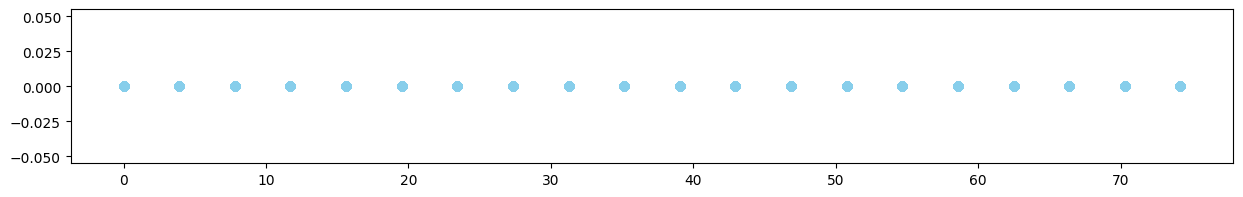

In [33]:
import matplotlib.pyplot as plt

y_aixs=[0 for _ in range(16000)]

plt.figure(figsize=(15,2))

plt.scatter(frame_data[:,[2]],y_aixs,color='skyblue')